# Adaptive Forecasting & Drift Diagnostics (5Y)

## Setup

In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path("..").resolve()))

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from src.data_loader import load_clean_data, get_experimental_dataset, feature_definitions, target_col_name
from src.detectors import RiverCompatiblePCA
from src.drift_injection import inject_synthetic_drift
from src.experiments import run_comparison_experiment, run_adaptive_forecasting_experiment

In [3]:
DATA_DIR = Path("../data/processed/")

df = load_clean_data(DATA_DIR)

all_features = df.select_dtypes(include=[np.number]).columns.tolist()

print(df.shape)
print(f"Number of features: {len(all_features)}")
df.head()

[INFO] Loaded data from: ../data/processed/data_5y.parquet
[INFO] Shape before cleaning: (210433, 113)
[INFO] NaNs before cleaning: 5807472
[INFO] Shape after cleaning: (210428, 113)
[INFO] Final NaN count: 0
(210428, 113)
Number of features: 113


,erzeugung_installierte_leistung__biomasse_mw,erzeugung_installierte_leistung__wasserkraft_mw,erzeugung_installierte_leistung__wind_onshore_mw,erzeugung_installierte_leistung__photovoltaik_mw,erzeugung_installierte_leistung__sonstige_erneuerbare_mw,erzeugung_installierte_leistung__steinkohle_mw,erzeugung_installierte_leistung__erdgas_mw,erzeugung_installierte_leistung__pumpspeicher_mw,erzeugung_installierte_leistung__sonstige_konventionelle_mw,erzeugung_installierte_leistung__wind_offshore_mw,...,lastfluss_ch__fahrplaene_mw,lastfluss_ch__physikalische_lastfluesse_mw,lastfluss_fr__fahrplaene_mw,lastfluss_fr__physikalische_lastfluesse_mw,lastverlauf_netzeinspeisung__last_mw,regelzonenlast__prognose_mw,regelzonenlast__ist_wert_mw,regelzonensaldo__regelzonensaldo_mw,vertikale_netzlast__prognose_mw,vertikale_netzlast__ist_wert_mw
ts,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:15:00,889.0,1366.0,1667.0,6170.0,22.0,5450.0,1414.0,2512.0,1199.0,7387.0,...,-161.0,-999.0,-826.0,609.0,5282.0,5322.0,5311.0,146.0,3876.0,3685.0
2020-01-01 00:30:00,889.0,1366.0,1667.0,6170.0,22.0,5450.0,1414.0,2512.0,1199.0,7387.0,...,-161.0,-1043.0,-826.0,643.0,5283.0,5226.0,5255.0,161.0,3859.0,3655.0
2020-01-01 00:45:00,889.0,1366.0,1667.0,6170.0,22.0,5450.0,1414.0,2512.0,1199.0,7387.0,...,-161.0,-1022.0,-826.0,598.0,5231.0,5175.0,5177.0,86.0,3788.0,3624.0
2020-01-01 01:00:00,889.0,1366.0,1667.0,6170.0,22.0,5450.0,1414.0,2512.0,1199.0,7387.0,...,-161.0,-997.0,-826.0,645.0,5442.0,5095.0,5153.0,257.0,3733.0,3567.0
2020-01-01 01:15:00,889.0,1366.0,1667.0,6170.0,22.0,5450.0,1414.0,2512.0,1199.0,7387.0,...,-136.0,-973.0,-815.0,519.0,5162.0,5066.0,5129.0,16.0,3709.0,3525.0


## Data Loading and Sanity Checks

In [ ]:
# 1. Load data
# Adjust path to your data directory
data_dir = Path("../data/processed/") 
df_full = load_clean_data(data_dir)

# 2. Test Feature Sets (Step 2 Verification)
print("\n--- TESTING SCENARIO GENERATION ---")

# Scenario A: Low Dim
print("1. Scenario Low:")
X_low, y = get_experimental_dataset(df_full, scenario="low")

# Scenario B: Mid Dim
print("\n2. Scenario Mid:")
X_mid, y = get_experimental_dataset(df_full, scenario="mid")

# Scenario C: High Dim (Real World Max)
print("\n3. Scenario High:")
X_high, y = get_experimental_dataset(df_full, scenario="high")

# Scenario D: Ultra High (Stress Test for RO2)
print("\n4. Scenario Noise:")
X_noise, y = get_experimental_dataset(df_full, scenario="noise")

# 3. Leakage Check
# Verify that the target variable is NOT present in the features
leakage_check = "verbrauch_realisiert__netzlast_mwh" in X_low.columns
print(f"\n[CHECK] Is target in features? {leakage_check} (Should be False)")

[INFO] Loaded data from: ../data/processed/data_5y.parquet
[INFO] Shape before cleaning: (210433, 113)
[INFO] NaNs before cleaning: 5807472
[INFO] Shape after cleaning: (210428, 113)
[INFO] Final NaN count: 0

--- TESTING SCENARIO GENERATION ---
1. Scenario Low:
[INFO] Dataset prepared for scenario 'low': X shape=(210428, 10), y shape=(210428,)

2. Scenario Mid:
[INFO] Dataset prepared for scenario 'mid': X shape=(210428, 40), y shape=(210428,)

3. Scenario High:
[INFO] Dataset prepared for scenario 'high': X shape=(210428, 112), y shape=(210428,)

4. Scenario Noise:
[INFO] Added 50 synthetic noise features for scenario 'noise'.
[INFO] Dataset prepared for scenario 'noise': X shape=(210428, 162), y shape=(210428,)

[CHECK] Is target in features? False (Should be False)


#  Feature Engineering & Experimental Setup

[INFO] Dataset prepared for scenario 'mid': X shape=(210428, 40), y shape=(210428,)
[INFO] Injecting drift into 12/40 features starting at index 20000.


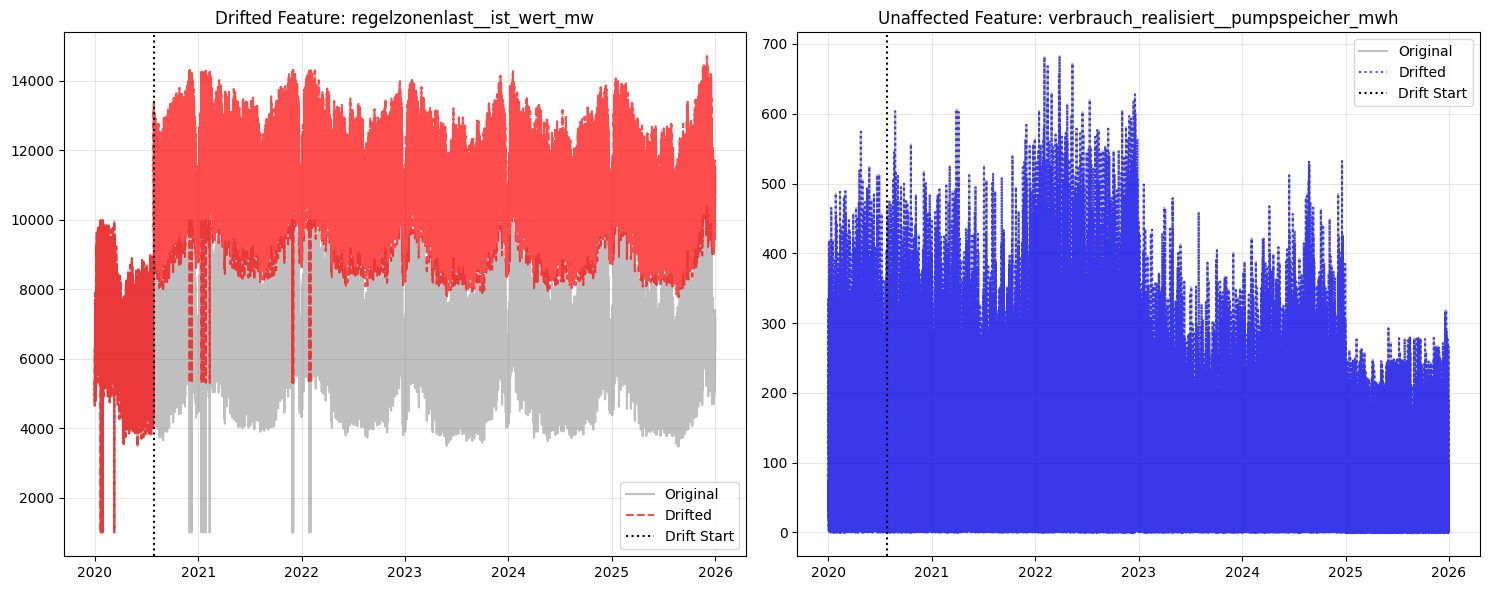

Ground Truth: Drift injected in features: ['regelzonenlast__ist_wert_mw', 'verbrauch_prog__residuallast_mwh', 'erzeugung_realisiert__pumpspeicher_mwh'] ...


In [5]:
X_mid, y = get_experimental_dataset(df_full, scenario="mid")

drift_idx = 20000  # Drift starts roughly after 2/3 of the year
magnitude = 3.0    # 3 Sigma shift (clearly visible)

# Inject Drift
X_drifted, affected_cols = inject_synthetic_drift(
    X_mid, 
    drift_start_idx=drift_idx, 
    magnitude_sigma=magnitude,
    affected_ratio=0.3 # 30% Feature Drift
)

# Visualization
affected_feat = affected_cols[0]
unaffected_feat = [c for c in X_mid.columns if c not in affected_cols][0]

plt.figure(figsize=(15, 6))

# Plot: Affected Feature
plt.subplot(1, 2, 1)
plt.plot(X_mid.index, X_mid[affected_feat], label='Original', alpha=0.5, color='gray')
plt.plot(X_drifted.index, X_drifted[affected_feat], label='Drifted', alpha=0.7, color='red', linestyle='--')
plt.axvline(X_mid.index[drift_idx], color='black', linestyle=':', label='Drift Start')
plt.title(f"Drifted Feature: {affected_feat}")
plt.legend()
plt.grid(True, alpha=0.3)

# Control Plot: Unaffected Feature
plt.subplot(1, 2, 2)
plt.plot(X_mid.index, X_mid[unaffected_feat], label='Original', alpha=0.5, color='gray')
plt.plot(X_drifted.index, X_drifted[unaffected_feat], label='Drifted', alpha=0.7, color='blue', linestyle=':') # Should overlap perfectly
plt.axvline(X_mid.index[drift_idx], color='black', linestyle=':', label='Drift Start')
plt.title(f"Unaffected Feature: {unaffected_feat}")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Ground Truth: Drift injected in features: {affected_cols[:3]} ...")

In [ ]:
print("=== RO2: DRIFT DETECTION BENCHMARK (LAB) ===")

# 1. We take a stable time slot
df_lab = df_full.iloc[35000:55000].copy()
X_lab = df_lab.drop(columns=[target_col_name])

# 2. Insert synthetic drift
drift_idx = 10000  # Drift genau in der Mitte
X_drifted_full, affected_cols = inject_synthetic_drift(
    X_lab, 
    drift_start_idx=drift_idx,
    magnitude_sigma=3.0,
    affected_ratio=0.3
)

# 3. Experiment for each scenario with filtered features
ro2_results = []
scenarios = ["low", "mid", "high"]

# Get feature names for each scenario
scenario_features = {}
for scen in scenarios:
    X_temp, _ = get_experimental_dataset(df_full, scenario=scen)
    scenario_features[scen] = X_temp.columns.tolist()
    print(f"Scenario {scen}: {len(scenario_features[scen])} features")

print("\n[INFO] Running RO2 experiments with scenario-specific feature sets...\n")

for scen in scenarios:
    # Filter X_drifted to onl1y include features for this scenario
    features_in_scenario = scenario_features[scen]
    X_filtered = X_drifted_full[features_in_scenario].copy()
    
    # Filter affected_cols to those present in this scenario
    affected_in_scenario = [col for col in affected_cols if col in features_in_scenario]
    
    res = run_comparison_experiment(
        X_filtered,
        drift_start_idx=drift_idx,
        affected_features=affected_in_scenario,
        scenario_name=scen
    )
    ro2_results.append(res)

#print("\nRO2 Results:")
#print(pd.DataFrame(ro2_results))

df_res = pd.DataFrame(ro2_results)
df_res = df_res.set_index("scenario")

=== RO2: DRIFT DETECTION BENCHMARK (LAB) ===
[INFO] Injecting drift into 33/112 features starting at index 10000.
[INFO] Dataset prepared for scenario 'low': X shape=(210428, 10), y shape=(210428,)
Scenario low: 10 features
[INFO] Dataset prepared for scenario 'mid': X shape=(210428, 40), y shape=(210428,)
Scenario mid: 40 features
[INFO] Dataset prepared for scenario 'high': X shape=(210428, 112), y shape=(210428,)
Scenario high: 112 features

[INFO] Running RO2 experiments with scenario-specific feature sets...


[START] Running experiment for scenario: 'low' (Features: 10)
   Step 0/20000 processed...
   Step 5000/20000 processed...
   Step 10000/20000 processed...
   Step 15000/20000 processed...
[DONE] Finished in 2.80s. Baseline FPR: 0.0443 | PCA FPR: 0.0049

[START] Running experiment for scenario: 'mid' (Features: 40)
   Step 0/20000 processed...
   Step 5000/20000 processed...
   Step 10000/20000 processed...
   Step 15000/20000 processed...
[DONE] Finished in 38.73s. Baseline

# Visuals


=== FINAL RESULTS TABLE (RO2) ===


,n_features,baseline_fpr,mitigation_fpr,baseline_latency,mitigation_latency
scenario,,,,,
low,10,0.0443,0.0049,72,139
mid,40,0.0965,0.0049,13,105
high,112,0.2581,0.0048,0,7


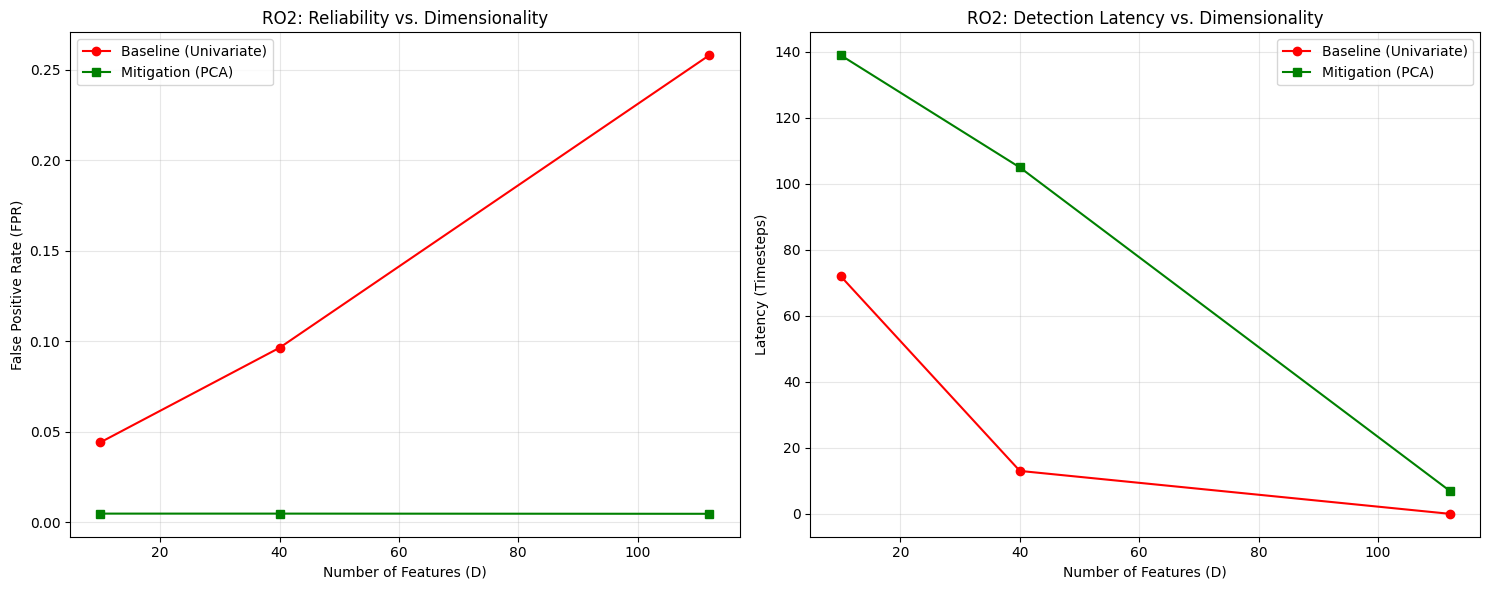

In [7]:
# Display Table
print("\n=== FINAL RESULTS TABLE (RO2) ===")
display(df_res[["n_features", "baseline_fpr", "mitigation_fpr", "baseline_latency", "mitigation_latency"]])

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Reliability (False Positive Rate)
# Expectation: Baseline FPR increases with dimensions, Mitigation stays low
axes[0].plot(df_res["n_features"], df_res["baseline_fpr"], marker='o', label="Baseline (Univariate)", color='red')
axes[0].plot(df_res["n_features"], df_res["mitigation_fpr"], marker='s', label="Mitigation (PCA)", color='green')
axes[0].set_title("RO2: Reliability vs. Dimensionality")
axes[0].set_xlabel("Number of Features (D)")
axes[0].set_ylabel("False Positive Rate (FPR)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Latency
axes[1].plot(df_res["n_features"], df_res["baseline_latency"], marker='o', label="Baseline (Univariate)", color='red')
axes[1].plot(df_res["n_features"], df_res["mitigation_latency"], marker='s', label="Mitigation (PCA)", color='green')
axes[1].set_title("RO2: Detection Latency vs. Dimensionality")
axes[1].set_xlabel("Number of Features (D)")
axes[1].set_ylabel("Latency (Timesteps)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Prepare X and y
X = df_full.drop(columns=[target_col_name])
y = df_full[target_col_name]

# Define the strategies to compare
strategies = ["baseline", "adwin", "grouped"]
results = {}

print("=== STARTING ADAPTIVE FORECASTING BATTLE ===\n")

for strat in strategies:
    # WICHTIG: Hier nutzen wir die echten Daten!
    res = run_adaptive_forecasting_experiment(
        X, 
        y, 
        detector_type=strat,
        feature_groups=feature_definitions # Braucht der Grouped Detector
    )
    results[strat] = res

print("RO3 Experiment Finished.")

=== STARTING ADAPTIVE FORECASTING BATTLE ===


[EXP] Starting Adaptive Forecasting with Strategy: BASELINE
   Stream step 5000/175428 | Retrainings so far: 0
   Stream step 10000/175428 | Retrainings so far: 0
   Stream step 15000/175428 | Retrainings so far: 0
   Stream step 20000/175428 | Retrainings so far: 0
   Stream step 25000/175428 | Retrainings so far: 0
   Stream step 30000/175428 | Retrainings so far: 0
   Stream step 35000/175428 | Retrainings so far: 0
   Stream step 40000/175428 | Retrainings so far: 0
   Stream step 45000/175428 | Retrainings so far: 0
   Stream step 50000/175428 | Retrainings so far: 0
   Stream step 55000/175428 | Retrainings so far: 0
   Stream step 60000/175428 | Retrainings so far: 0
   Stream step 65000/175428 | Retrainings so far: 0
   Stream step 70000/175428 | Retrainings so far: 0
   Stream step 75000/175428 | Retrainings so far: 0
   Stream step 80000/175428 | Retrainings so far: 0
   Stream step 85000/175428 | Retrainings so far: 0
   Stream 

In [9]:
# Create a comparison dataframe
comparison_data = []

for strat, res in results.items():
    comparison_data.append({
        "Strategy": strat.upper(),
        "RMSE": res["rmse"],
        "Retrainings": len(res["retrain_steps"]),
        "Last_Retrain_Step": res["retrain_steps"][-1] if res["retrain_steps"] else 0
    })

df_comp = pd.DataFrame(comparison_data).sort_values("RMSE")

print("Final Results Table:")
display(df_comp)

Final Results Table:


,Strategy,RMSE,Retrainings,Last_Retrain_Step
2,GROUPED,91.489298,337,175219
1,ADWIN,91.554604,286,174687
0,BASELINE,743.720398,0,0


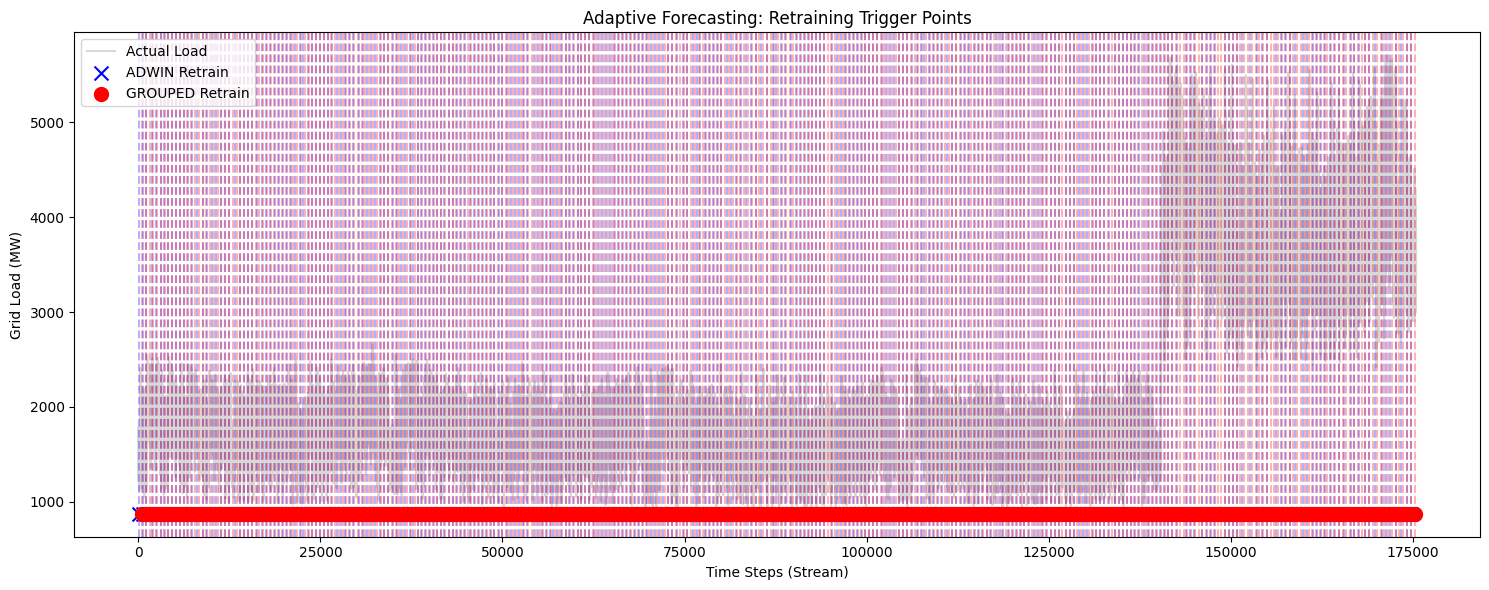

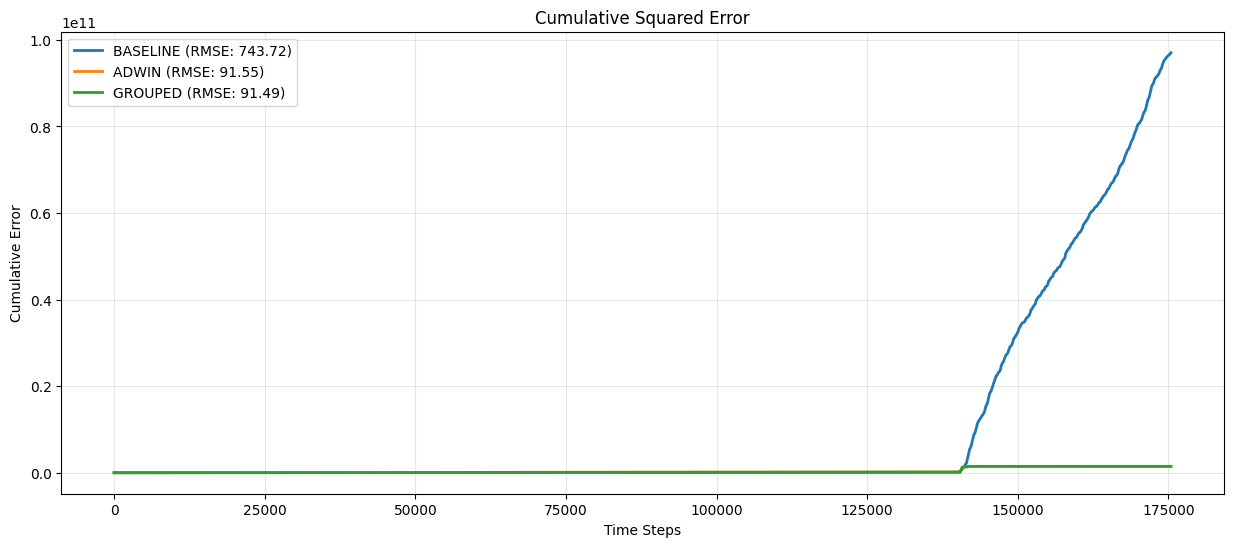

In [10]:
# Plotting the Retraining Points
plt.figure(figsize=(15, 6))

# 1. Plot the actual Target (Light gray in background)
# We take the actuals from one of the results (they are the same for all)
actual_values = results["baseline"]["actuals"]
plt.plot(actual_values, color='gray', alpha=0.3, label="Actual Load")

# 2. Plot Retraining Events for each strategy
colors = {"baseline": "black", "adwin": "blue", "grouped": "red"}
markers = {"baseline": "", "adwin": "x", "grouped": "o"}

# Offset for visualization (so dots don't overlap perfectly)
y_min = min(actual_values)
offsets = {"baseline": 0, "adwin": y_min * 0.05, "grouped": y_min * 0.1}

for strat in ["adwin", "grouped"]:
    steps = results[strat]["retrain_steps"]
    # We plot vertical lines or dots where retraining happened
    # Since 'steps' are indices relative to the stream start:
    y_vals = [min(actual_values)] * len(steps) # Plot dots at the bottom
    
    plt.scatter(steps, y_vals, color=colors[strat], marker=markers[strat], s=100, label=f"{strat.upper()} Retrain", zorder=5)
    
    # Optional: Vertical lines
    for s in steps:
        plt.axvline(s, color=colors[strat], alpha=0.3, linestyle="--")

plt.title("Adaptive Forecasting: Retraining Trigger Points")
plt.xlabel("Time Steps (Stream)")
plt.ylabel("Grid Load (MW)")
plt.legend()
plt.tight_layout()
plt.show()

# Extra Plot: Cumulative Error (Who is better over time?)
plt.figure(figsize=(15, 6))

for strat in strategies:
    preds = results[strat]["predictions"]
    acts = results[strat]["actuals"]
    
    # Calculate Squared Error per step
    se = (np.array(preds) - np.array(acts)) ** 2
    # Cumulative Sum
    cse = np.cumsum(se)
    
    plt.plot(cse, label=f"{strat.upper()} (RMSE: {results[strat]['rmse']:.2f})", linewidth=2)

plt.title("Cumulative Squared Error")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Error")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

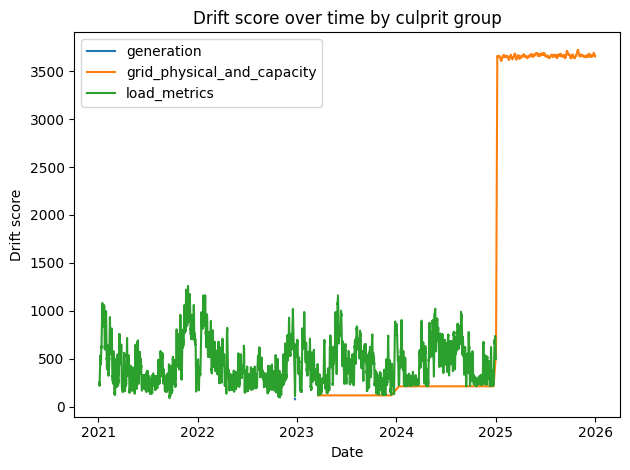

In [12]:
if "grouped" in results:
    drift_reasons = results["grouped"]["drift_reasons"]
else:
    print("Strategie 'grouped' nicht in den Ergebnissen gefunden.")
    drift_reasons = []

df = pd.DataFrame(drift_reasons).copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date", "culprit_group", "score"]).sort_values("date")

plt.figure()
for g, sub in df.groupby("culprit_group"):
    plt.plot(sub["date"].values, sub["score"].values, label=str(g))

plt.xlabel("Date")
plt.ylabel("Drift score")
plt.title("Drift score over time by culprit group")
plt.legend()
plt.tight_layout()
plt.show()

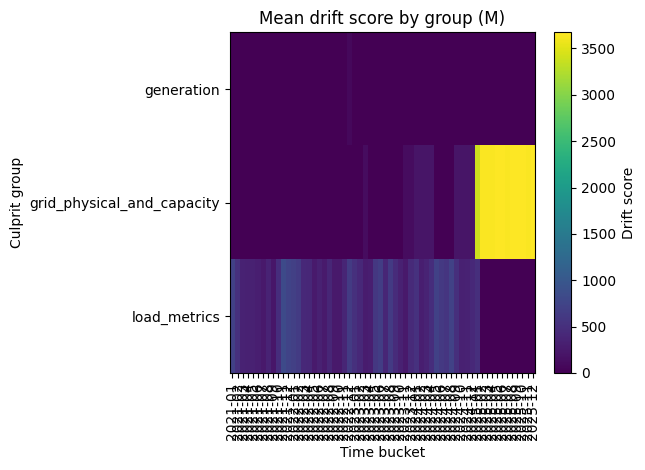

In [13]:
df = pd.DataFrame(drift_reasons).copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date", "culprit_group", "score"]).sort_values("date")

# Time-Aggregation: "M" = month, "W" = week, "Q" = quartal
freq = "M"
df["bucket"] = df["date"].dt.to_period(freq).dt.to_timestamp()

# Aggregation: mean oder max
pv = df.pivot_table(
    index="culprit_group",
    columns="bucket",
    values="score",
    aggfunc="mean",   # alternativ: "max"
    fill_value=0.0,
)

plt.figure()
plt.imshow(pv.values, aspect="auto")
plt.yticks(np.arange(len(pv.index)), pv.index.astype(str))
plt.xticks(
    np.arange(len(pv.columns)),
    [c.strftime("%Y-%m") for c in pv.columns],
    rotation=90,
)
plt.xlabel("Time bucket")
plt.ylabel("Culprit group")
plt.title(f"Mean drift score by group ({freq})")
plt.colorbar(label="Drift score")
plt.tight_layout()
plt.show()

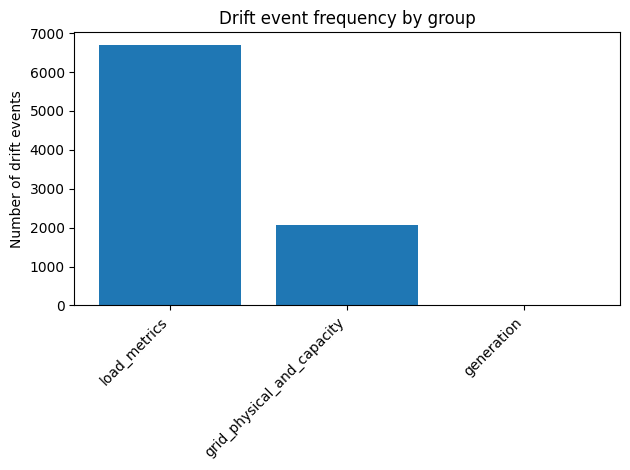

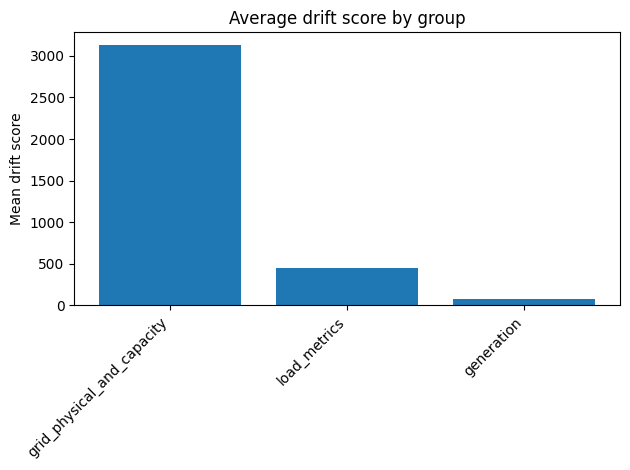

In [14]:
df = pd.DataFrame(drift_reasons).copy()
counts = df["culprit_group"].value_counts()

plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of drift events")
plt.title("Drift event frequency by group")
plt.tight_layout()
plt.show()

df = pd.DataFrame(drift_reasons).copy()
mean_scores = (
    df.groupby("culprit_group")["score"]
      .mean()
      .sort_values(ascending=False)
)

plt.figure()
plt.bar(mean_scores.index.astype(str), mean_scores.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean drift score")
plt.title("Average drift score by group")
plt.tight_layout()
plt.show()